In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For ROC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Miscellaneous
from tqdm import tqdm
import os
import random


# # <b>2 <span style='color:#4285f4'>|</span> Reading the Dataset</b>

In [2]:
train_dir = './train/'
test_dir = './test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

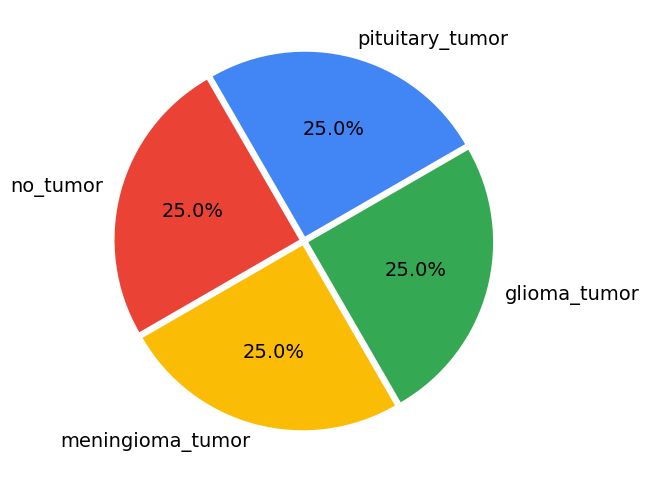

In [3]:
# Directory containing training data
dir_train = './train'

# Initialize empty lists for labels and counts
class_labels = ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
class_counts = []

# Iterate over classes and count the number of images in each one
for class_name in class_labels:
    class_dir = os.path.join(dir_train, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts.append(class_count)

# Define colors and other settings for the pie chart
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 14})
plt.pie(class_counts, labels=class_labels, colors=colors, autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025), startangle=30)

# Display the pie chart
plt.show()


# #### The dataset is reasonably balanced



test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

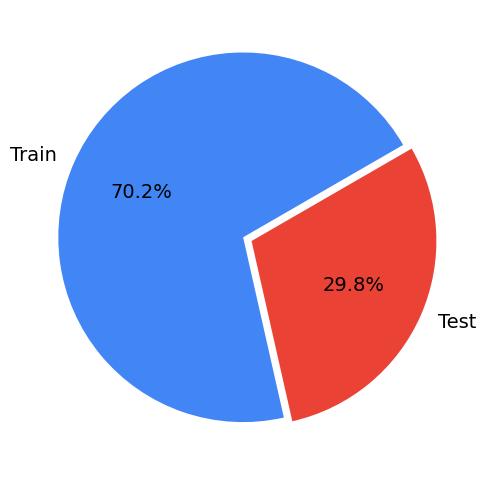

In [4]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);


# # <b>3 <span style='color:#4285f4'>|</span> Data Augmentation</b>
# - Random Brightness: 80% - 120%  
# - Random Contrast: 80% - 120%
# 

In [5]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image


# <h3 style="font-family:Sans;">Let's plot some Samples :</h3>

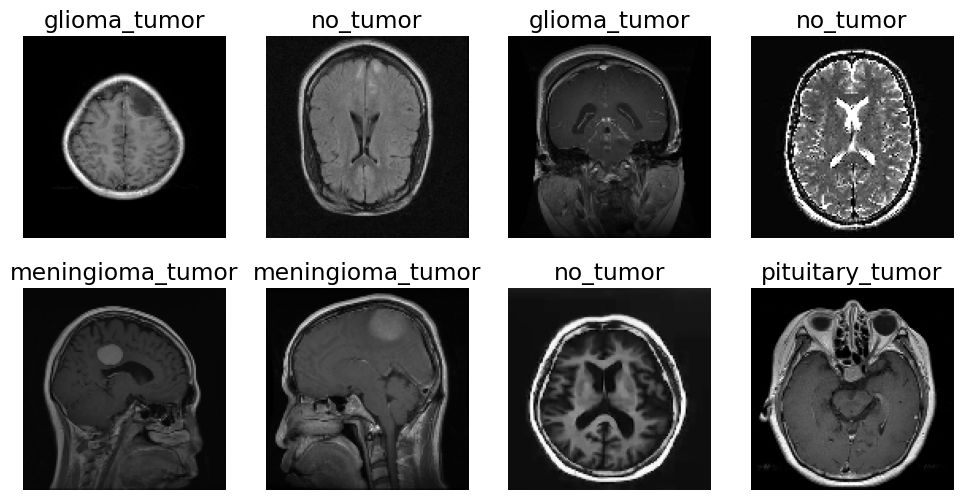

In [6]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()


# # <b>4 <span style='color:#4285f4'>|</span> Data Generator</b>
# <p style="font-size:15px; font-family:Sans; line-height: 1.7em">
#     Given a list of paths to images, and the labels, <br>
#     this function augments the images, normalizes them, encodes the label, and then returns the batch on which the model can train on. <br>
# </p>

In [7]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels


# # <b>5 <span style='color:#4285f4'>|</span> Model</b>

# ### I am using **VGG16** for transfer learning

In [8]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add

(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128644 (31.01 MB)
_________________________________________________________________
 Layer (type)                Output Shape          

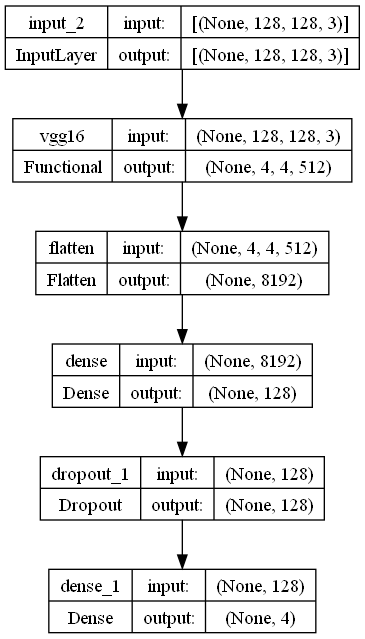

In [10]:
keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])


# # <b>6 <span style='color:#4285f4'>|</span> Train Model</b>

In [12]:
batch_size = 10
steps = int(len(train_paths)/batch_size)
epochs = 15
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/15
646/646 [==============================] - 272s 419ms/step - loss: 0.4092 - sparse_categorical_accuracy: 0.8426
Epoch 2/15
646/646 [==============================] - 266s 412ms/step - loss: 0.2013 - sparse_categorical_accuracy: 0.9209
Epoch 3/15
646/646 [==============================] - 266s 412ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.9546
Epoch 4/15
646/646 [==============================] - 900s 1s/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9717
Epoch 5/15
646/646 [==============================] - 275s 426ms/step - loss: 0.0646 - sparse_categorical_accuracy: 0.9782
Epoch 6/15
646/646 [==============================] - 273s 423ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9806
Epoch 7/15
646/646 [==============================] - 274s 425ms/step - loss: 0.0387 - sparse_categorical_accuracy: 0.9851
Epoch 8/15
646/646 [==============================] - 270s 417ms/step - loss: 0.0500 - sparse_categorical_accuracy: 0.9842
Epoch 9/15
646/646 

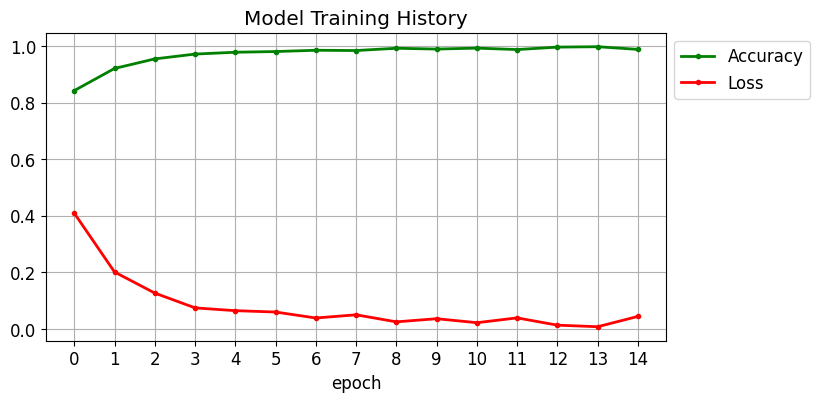

In [13]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# # <b>7 <span style='color:#4285f4'>|</span> Evaluate Model with Test Samples</b>

In [14]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/85 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  1%|          | 1/85 [00:01<02:05,  1.50s/it]

1/1 [==============================] - 1s 875ms/step


  2%|▏         | 2/85 [00:02<01:48,  1.31s/it]

1/1 [==============================] - 1s 901ms/step


  4%|▎         | 3/85 [00:03<01:42,  1.25s/it]

1/1 [==============================] - 1s 856ms/step


  5%|▍         | 4/85 [00:04<01:36,  1.20s/it]

1/1 [==============================] - 1s 847ms/step


  6%|▌         | 5/85 [00:06<01:32,  1.15s/it]

1/1 [==============================] - 1s 848ms/step


  7%|▋         | 6/85 [00:07<01:29,  1.13s/it]

1/1 [==============================] - 1s 860ms/step


  8%|▊         | 7/85 [00:08<01:27,  1.13s/it]

1/1 [==============================] - 1s 850ms/step


  9%|▉         | 8/85 [00:09<01:25,  1.11s/it]

1/1 [==============================] - 1s 856ms/step


 11%|█         | 9/85 [00:10<01:24,  1.11s/it]

1/1 [==============================] - 1s 873ms/step


 12%|█▏        | 10/85 [00:11<01:23,  1.12s/it]

1/1 [==============================] - 1s 854ms/step


 13%|█▎        | 11/85 [00:12<01:22,  1.11s/it]

1/1 [==============================] - 1s 893ms/step


 14%|█▍        | 12/85 [00:13<01:22,  1.13s/it]

1/1 [==============================] - 1s 930ms/step


 15%|█▌        | 13/85 [00:15<01:24,  1.17s/it]

1/1 [==============================] - 1s 870ms/step


 16%|█▋        | 14/85 [00:16<01:23,  1.17s/it]

1/1 [==============================] - 1s 903ms/step


 18%|█▊        | 15/85 [00:17<01:22,  1.17s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▉        | 16/85 [00:18<01:24,  1.22s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 17/85 [00:20<01:30,  1.33s/it]

1/1 [==============================] - 1s 901ms/step


 21%|██        | 18/85 [00:21<01:28,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 19/85 [00:23<01:27,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 24%|██▎       | 20/85 [00:24<01:28,  1.36s/it]

1/1 [==============================] - 1s 916ms/step


 25%|██▍       | 21/85 [00:25<01:24,  1.32s/it]

1/1 [==============================] - 1s 840ms/step


 26%|██▌       | 22/85 [00:26<01:19,  1.26s/it]

1/1 [==============================] - 1s 814ms/step


 27%|██▋       | 23/85 [00:27<01:14,  1.20s/it]

1/1 [==============================] - 1s 752ms/step


 28%|██▊       | 24/85 [00:28<01:08,  1.13s/it]

1/1 [==============================] - 1s 749ms/step


 29%|██▉       | 25/85 [00:29<01:04,  1.08s/it]

1/1 [==============================] - 1s 871ms/step


 31%|███       | 26/85 [00:30<01:04,  1.09s/it]

1/1 [==============================] - 1s 798ms/step


 32%|███▏      | 27/85 [00:31<01:02,  1.07s/it]

1/1 [==============================] - 1s 749ms/step


 33%|███▎      | 28/85 [00:32<00:59,  1.04s/it]

1/1 [==============================] - 1s 768ms/step


 34%|███▍      | 29/85 [00:33<00:57,  1.02s/it]

1/1 [==============================] - 1s 835ms/step


 35%|███▌      | 30/85 [00:34<00:57,  1.04s/it]

1/1 [==============================] - 1s 838ms/step


 36%|███▋      | 31/85 [00:36<00:56,  1.05s/it]

1/1 [==============================] - 1s 881ms/step


 38%|███▊      | 32/85 [00:37<00:58,  1.10s/it]

1/1 [==============================] - 1s 917ms/step


 39%|███▉      | 33/85 [00:38<00:58,  1.12s/it]

1/1 [==============================] - 1s 859ms/step


 40%|████      | 34/85 [00:39<00:56,  1.12s/it]

1/1 [==============================] - 1s 933ms/step


 41%|████      | 35/85 [00:40<00:56,  1.14s/it]

1/1 [==============================] - 1s 824ms/step


 42%|████▏     | 36/85 [00:42<00:59,  1.22s/it]

1/1 [==============================] - 1s 818ms/step


 44%|████▎     | 37/85 [00:43<01:01,  1.28s/it]

1/1 [==============================] - 1s 856ms/step


 45%|████▍     | 38/85 [00:44<00:57,  1.23s/it]

1/1 [==============================] - 1s 845ms/step


 46%|████▌     | 39/85 [00:45<00:54,  1.19s/it]

1/1 [==============================] - 1s 860ms/step


 47%|████▋     | 40/85 [00:46<00:52,  1.18s/it]

1/1 [==============================] - 1s 777ms/step


 48%|████▊     | 41/85 [00:47<00:49,  1.12s/it]

1/1 [==============================] - 1s 759ms/step


 49%|████▉     | 42/85 [00:48<00:46,  1.08s/it]

1/1 [==============================] - 1s 910ms/step


 51%|█████     | 43/85 [00:50<00:46,  1.10s/it]

1/1 [==============================] - 1s 791ms/step


 52%|█████▏    | 44/85 [00:51<00:44,  1.09s/it]

1/1 [==============================] - 1s 782ms/step


 53%|█████▎    | 45/85 [00:52<00:43,  1.08s/it]

1/1 [==============================] - 1s 766ms/step


 54%|█████▍    | 46/85 [00:53<00:41,  1.06s/it]

1/1 [==============================] - 1s 851ms/step


 55%|█████▌    | 47/85 [00:54<00:40,  1.07s/it]

1/1 [==============================] - 1s 767ms/step


 56%|█████▋    | 48/85 [00:55<00:39,  1.07s/it]

1/1 [==============================] - 1s 806ms/step


 58%|█████▊    | 49/85 [00:56<00:38,  1.06s/it]

1/1 [==============================] - 1s 761ms/step


 59%|█████▉    | 50/85 [00:57<00:36,  1.04s/it]

1/1 [==============================] - 1s 756ms/step


 60%|██████    | 51/85 [00:58<00:34,  1.02s/it]

1/1 [==============================] - 1s 768ms/step


 61%|██████    | 52/85 [00:59<00:33,  1.01s/it]

1/1 [==============================] - 1s 754ms/step


 62%|██████▏   | 53/85 [01:00<00:32,  1.00s/it]

1/1 [==============================] - 1s 861ms/step


 64%|██████▎   | 54/85 [01:01<00:31,  1.03s/it]

1/1 [==============================] - 1s 836ms/step


 65%|██████▍   | 55/85 [01:02<00:31,  1.05s/it]

1/1 [==============================] - 1s 822ms/step


 66%|██████▌   | 56/85 [01:03<00:30,  1.05s/it]

1/1 [==============================] - 1s 888ms/step


 67%|██████▋   | 57/85 [01:04<00:29,  1.07s/it]

1/1 [==============================] - 1s 877ms/step


 68%|██████▊   | 58/85 [01:05<00:29,  1.09s/it]

1/1 [==============================] - 1s 874ms/step


 69%|██████▉   | 59/85 [01:06<00:28,  1.11s/it]

1/1 [==============================] - 1s 837ms/step


 71%|███████   | 60/85 [01:08<00:27,  1.10s/it]

1/1 [==============================] - 1s 803ms/step


 72%|███████▏  | 61/85 [01:09<00:26,  1.10s/it]

1/1 [==============================] - 1s 849ms/step


 73%|███████▎  | 62/85 [01:10<00:25,  1.09s/it]

1/1 [==============================] - 1s 941ms/step


 74%|███████▍  | 63/85 [01:11<00:24,  1.13s/it]

1/1 [==============================] - 1s 880ms/step


 75%|███████▌  | 64/85 [01:12<00:23,  1.14s/it]

1/1 [==============================] - 1s 845ms/step


 76%|███████▋  | 65/85 [01:13<00:22,  1.12s/it]

1/1 [==============================] - 1s 880ms/step


 78%|███████▊  | 66/85 [01:14<00:21,  1.15s/it]

1/1 [==============================] - 1s 822ms/step


 79%|███████▉  | 67/85 [01:16<00:20,  1.16s/it]

1/1 [==============================] - 1s 896ms/step


 80%|████████  | 68/85 [01:17<00:19,  1.17s/it]

1/1 [==============================] - 1s 878ms/step


 81%|████████  | 69/85 [01:18<00:19,  1.20s/it]

1/1 [==============================] - 1s 837ms/step


 82%|████████▏ | 70/85 [01:19<00:17,  1.17s/it]

1/1 [==============================] - 1s 910ms/step


 84%|████████▎ | 71/85 [01:20<00:16,  1.17s/it]

1/1 [==============================] - 1s 851ms/step


 85%|████████▍ | 72/85 [01:21<00:15,  1.17s/it]

1/1 [==============================] - 1s 887ms/step


 86%|████████▌ | 73/85 [01:23<00:14,  1.19s/it]

1/1 [==============================] - 1s 887ms/step


 87%|████████▋ | 74/85 [01:24<00:13,  1.26s/it]

1/1 [==============================] - 1s 906ms/step


 88%|████████▊ | 75/85 [01:25<00:12,  1.26s/it]

1/1 [==============================] - 1s 997ms/step


 89%|████████▉ | 76/85 [01:27<00:11,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 77/85 [01:28<00:10,  1.35s/it]

1/1 [==============================] - 1s 933ms/step


 92%|█████████▏| 78/85 [01:30<00:09,  1.36s/it]

1/1 [==============================] - 1s 931ms/step


 93%|█████████▎| 79/85 [01:31<00:08,  1.35s/it]

1/1 [==============================] - 1s 953ms/step


 94%|█████████▍| 80/85 [01:32<00:06,  1.32s/it]

1/1 [==============================] - 1s 974ms/step


 95%|█████████▌| 81/85 [01:33<00:05,  1.32s/it]

1/1 [==============================] - 1s 952ms/step


 96%|█████████▋| 82/85 [01:35<00:04,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 83/85 [01:36<00:02,  1.36s/it]

1/1 [==============================] - 1s 976ms/step


 99%|█████████▉| 84/85 [01:38<00:01,  1.37s/it]

1/1 [==============================] - 1s 931ms/step


100%|██████████| 85/85 [01:39<00:00,  1.33s/it]

1/1 [==============================] - 1s 907ms/step


86it [01:40,  1.17s/it]                        
86it [01:40,  1.17s/it]


In [15]:
print(classification_report(y_true, y_pred))

                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.59      0.74       686
meningioma_tumor       0.94      0.98      0.96       684
        no_tumor       0.97      1.00      0.98       683
 pituitary_tumor       0.72      0.95      0.81       692

        accuracy                           0.88      2745
       macro avg       0.90      0.88      0.87      2745
    weighted avg       0.90      0.88      0.87      2745



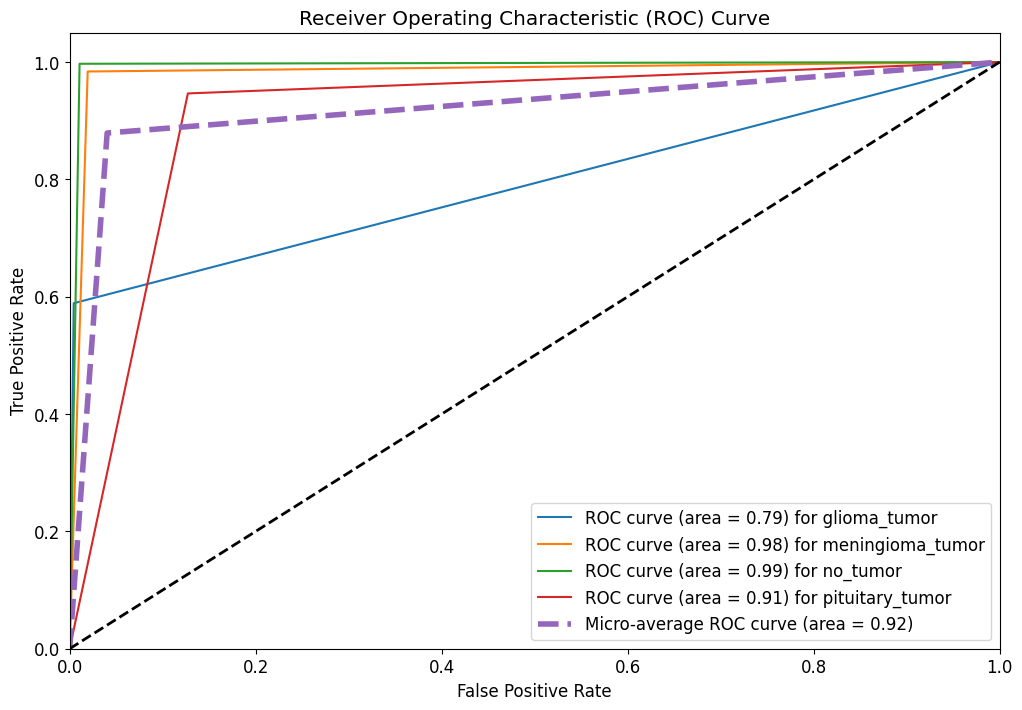

In [16]:
# Converte as labels para one-hot encoding
y_true_one_hot = label_binarize(y_true, classes=unique_labels)
y_pred_one_hot = label_binarize(y_pred, classes=unique_labels)

# Calcula a curva ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(unique_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcula a média da curva ROC para todas as classes
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_one_hot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plota a curva ROC para cada classe
plt.figure(figsize=(12, 8))
for i in range(len(unique_labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {unique_labels[i]}')

# Plota a curva ROC média
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})', linestyle='--', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

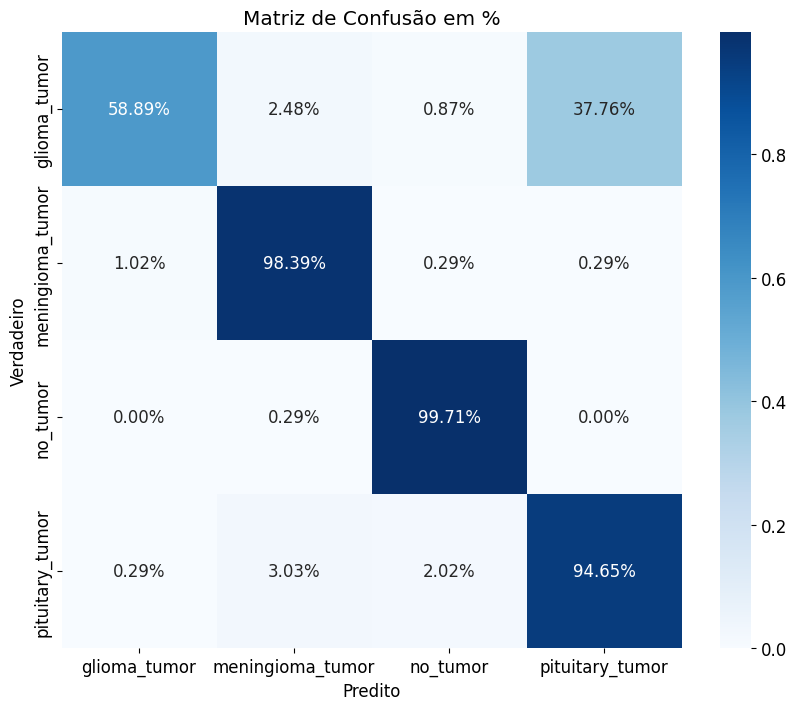

In [21]:
# Calcula a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Calcula a matriz de confusão em termos percentuais
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plota a matriz de confusão em termos percentuais usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matriz de Confusão em %')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()